# Non-stationary [SCM-MAB](https://papers.nips.cc/paper/2018/hash/c0a271bc0ecb776a094786474322cb82-Abstract.html)

- Need to allow for prior on causal effects (--> Bayesian MAB)
- Non-stationary Bayesian structural causal MAB
    - Non-stationary because the reward statistics changes across time
    - Bayesian because we have a prior on the reward distribution
    - Structural because we are of the causal structure of the reward distribution 

## Stationarity assumptions of standard MAB algorithms

- Thompson Sampling (Thompson, 1933), UCB and epsilon-greedy assume that the rewards are i.i.d. samples from stationary distributions (Allesiardo et al., 2017), thus are not suitable for the (DBN-like underyling CGM) application.
- The EXP3 (Auer et al., 2002b) MAB algorithm makes comparatively fewer assumptions on reward distributions and can deal with the general setting of adversarially-defined rewards. The general adversarial bandit setting is important for our application as it enables the MAB to handle the non-stationary nature of the rewards observed during the optimisation (Allesiardo et al., 2017).

## Considerations

- Appears to be a so-called 'restless bandit problem'
- _Sometimes_ we have observational data, so we have a strong prior on the reward distribution
- We are doing inference on the reward distribution (exploring it) whilst playing the game, this means we are dealing with NS-MAB.
- At the start of the game, all we have is a prior on the reward distribution (one for each exploration set) but as we play the game, we collect more observations, update our prior, and then continue the game until we find the best arm. 
    - **CONTINUOUS CAUSAL EFFECTS** As we play the game, BO will tell us _where_ on the selected arm to explore

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
sys.path.append("..")
sys.path.append("../src")
import multiprocessing

In [2]:
from src.utils.dag_utils.graph_functions import make_graphical_model, make_networkx_object, get_time_slice_sub_graphs

In [3]:
from npsem.model import CausalDiagram
from npsem.where_do import MISs, MUCT, IB, POMISs, MUCT_IB
from npsem.utils import combinations, subseq
from npsem.NIPS2018POMIS_exp.scm_examples import IV_SCM
from npsem.scm_bandits import SCM_to_bandit_machine, arms_of, arm_types
from npsem.bandits import play_bandits

# Non-stationary SCM-MAB as piece-wise stationary SCM-MAB 

SCM-MAB will be run on the DAG in each time-slice (which could change across time). The reward distribution will change as we step through the graph, from left to right.

In [16]:
node_info = {"X": {"type": "manipulative", "domain": (0,1)},
             "Z": {"type": "manipulative", "domain": (0,1)},
             "Y": {"type": "manipulative", "domain": (-1,1)},
             "U": {"type": "confounder"}}
# Constructor for adding unobserved confounder to graph
uc_constructor = {0: ("Z","Y"), 1:  ("X","Y")}

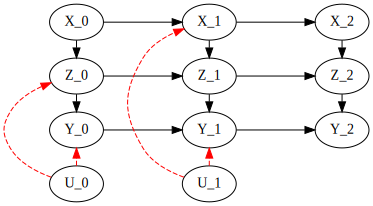

In [17]:
T = 3
graph_view = make_graphical_model(0,
T-1,
topology='dependent',
target_node = 'Y',
node_information= node_info,
confounder_info= uc_constructor,
verbose=True) # Base topology
graph_view

In [9]:
import networkx as nx

In [38]:
G = make_networkx_object(graph_view, node_info)
# Contains all the sub-graphs per time-slice
gs = get_time_slice_sub_graphs(G,T)

In [73]:
uc_constructor[0] + ('test',)

('Z', 'Y', 'test')

In [69]:
[node.split("_")[0] for node in gs[0].nodes if node_info[node.split("_")[0]]['type'] != "confounder"]

['Z', 'Y', 'X']

In [55]:
# We don't really need this as it's provided in the constructor
[edge for edge in edges if any(gs[1].nodes[v]['type'] == 'confounder' for v in edge)]

[('U_1', 'X_1'), ('U_1', 'Y_1')]

In [102]:
edges = [e[:-1] for e in gs[1].edges]
directed_edges = [edge for edge in edges if all(gs[1].nodes[v]['type'] != 'confounder' for v in edge)]
directed_edges = [tuple([v.split("_")[0] for v in edge]) for edge in directed_edges]

[('X', 'Z'), ('Z', 'Y'), ('U', 'X'), ('U', 'Y')]


TODO:

4. Loop through each sub-graph and for each index 

### Explore SCM from fig 3

In [13]:
num_trial = 1
horizon = 20
n_jobs = 2
Y = "Y"

In [14]:
M, p_u = IV_SCM(devised=True,seed=0)
mu, arm_setting = SCM_to_bandit_machine(M)

In [29]:
arm_strategy = 'Brute-force'
bandit_algo = 'TS'
arm_selected = arms_of(arm_strategy, arm_setting, M.G, Y)
arm_corrector = np.vectorize(lambda x: arm_selected[x])

In [79]:
subseq(mu, arm_selected)

(0.4454,
 0.493,
 0.5070000000000001,
 0.773,
 0.22700000000000004,
 0.493,
 0.493,
 0.5070000000000001,
 0.5070000000000001)

In [74]:
 arm_played, rewards = play_bandits(horizon, subseq(mu, arm_selected), bandit_algo, num_trial, n_jobs)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.5s finished


In [77]:
rewards

array([[0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 0.]])